Labeled sequence of bitter peptides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool, Set2Set

In [3]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [4]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [5]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Positive,GFF
1,Positive,VYPFPPGIGG
2,Positive,EVLN
3,Positive,KAVPYPPQ
4,Positive,FV
...,...,...
635,Negative,MIFPGGPQL
636,Negative,HHL
637,Negative,HIR
638,Negative,NILP


In [6]:
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [7]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [8]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [9]:
data_list = []

In [10]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [11]:
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=6)

In [12]:
train_data[0], test_data[0]

(Data(x=[7, 20], edge_index=[2, 12], y=1),
 Data(x=[4, 20], edge_index=[2, 6], y=1))

In [13]:
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=64)

In [14]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[127, 20], edge_index=[2, 190], y=[32], batch=[127], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[142, 20], edge_index=[2, 220], y=[32], batch=[142], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[169, 20], edge_index=[2, 274], y=[32], batch=[169], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[210, 20], edge_index=[2, 356], y=[32], batch=[210], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[176, 20], edge_index=[2, 288], y=[32], batch=[176], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[183, 20], edge_index=[2, 302], y=[32], batch=[183], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[179, 20], edge_index=[2, 294], y=[32], batch=[179], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[174, 20], edge_index=[2, 284], y=[32], batch=[174], ptr

In [15]:
class gcnlstm(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(gcnlstm, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.seqpool = Set2Set(hidden_channels, 1)
        self.lin = Linear(hidden_channels*2, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        # 2. Readout layer
        x = self.seqpool(x, batch)  # [batch_size, hidden_channels]
        #x = global_mean_pool(x, batch)
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = gcnlstm(hidden_channels=64)
print(model)

gcnlstm(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (seqpool): Set2Set(64, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [16]:
hidden_channels = 16
epochs = 30

In [17]:
model = gcnlstm(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.7639, Test Acc: 0.6562
Epoch: 001, Train Acc: 0.8090, Test Acc: 0.7031
Epoch: 002, Train Acc: 0.7969, Test Acc: 0.7656
Epoch: 003, Train Acc: 0.8472, Test Acc: 0.8281
Epoch: 004, Train Acc: 0.8559, Test Acc: 0.8438
Epoch: 005, Train Acc: 0.8559, Test Acc: 0.7812
Epoch: 006, Train Acc: 0.8611, Test Acc: 0.8281
Epoch: 007, Train Acc: 0.8681, Test Acc: 0.8594
Epoch: 008, Train Acc: 0.8715, Test Acc: 0.8594
Epoch: 009, Train Acc: 0.8941, Test Acc: 0.8594
Epoch: 010, Train Acc: 0.8854, Test Acc: 0.8438
Epoch: 011, Train Acc: 0.8854, Test Acc: 0.7969
Epoch: 012, Train Acc: 0.8837, Test Acc: 0.7812
Epoch: 013, Train Acc: 0.8767, Test Acc: 0.7969
Epoch: 014, Train Acc: 0.8872, Test Acc: 0.8438
Epoch: 015, Train Acc: 0.9028, Test Acc: 0.8594
Epoch: 016, Train Acc: 0.9115, Test Acc: 0.8594
Epoch: 017, Train Acc: 0.9201, Test Acc: 0.8906
Epoch: 018, Train Acc: 0.9010, Test Acc: 0.8125
Epoch: 019, Train Acc: 0.9028, Test Acc: 0.7969
Epoch: 020, Train Acc: 0.9010, Test Acc:

In [18]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [19]:
out.shape

torch.Size([64, 2])

In [20]:
lab.shape

torch.Size([64])

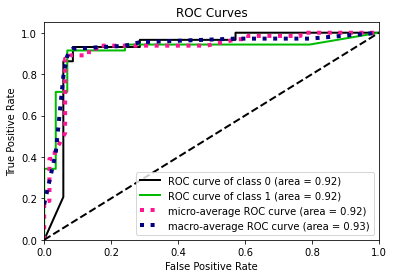

In [21]:
skplt.metrics.plot_roc(lab, out.detach().numpy())
plt.show()

In [22]:
model

gcnlstm(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (seqpool): Set2Set(16, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [24]:
layer_name = 'conv3'

In [25]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation(layer_name))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation[layer_name]

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [26]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    lab = data.y

    model.conv3.register_forward_hook(get_activation(layer_name))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation[layer_name]

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [27]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

## Graph level embedding

### All embeddings

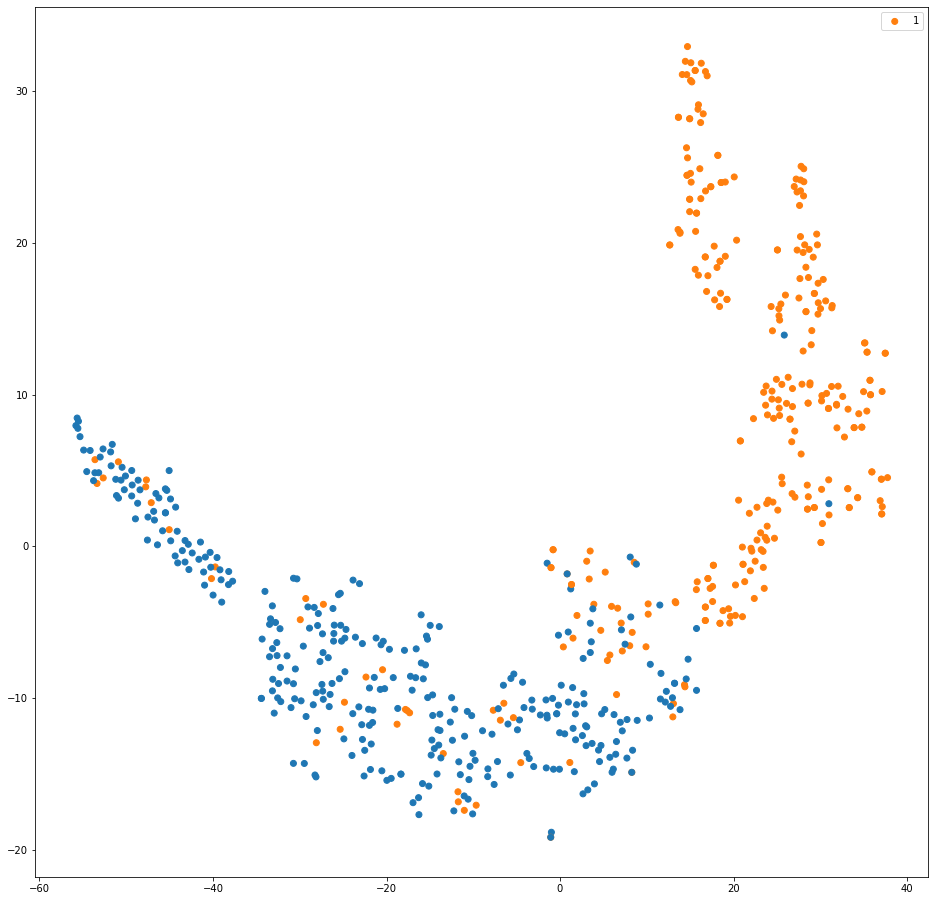

In [28]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

### Train

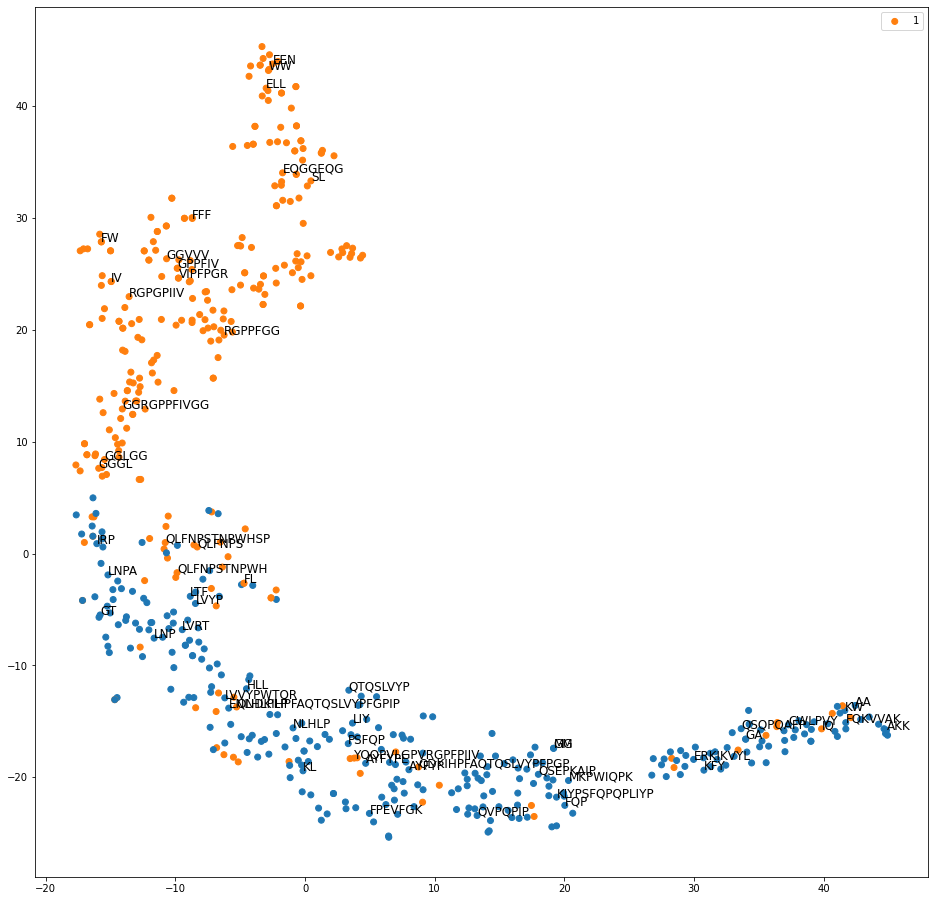

In [29]:
descs = []
conv_feats = np.zeros((len(train_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(train_graph_embeddings)):
    descs.append(train_graph_embeddings[i]['desc'])
    conv_feats[i] = train_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(train_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    if i%10 ==0:
        plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]), size = 12)
plt.show()

#### Test

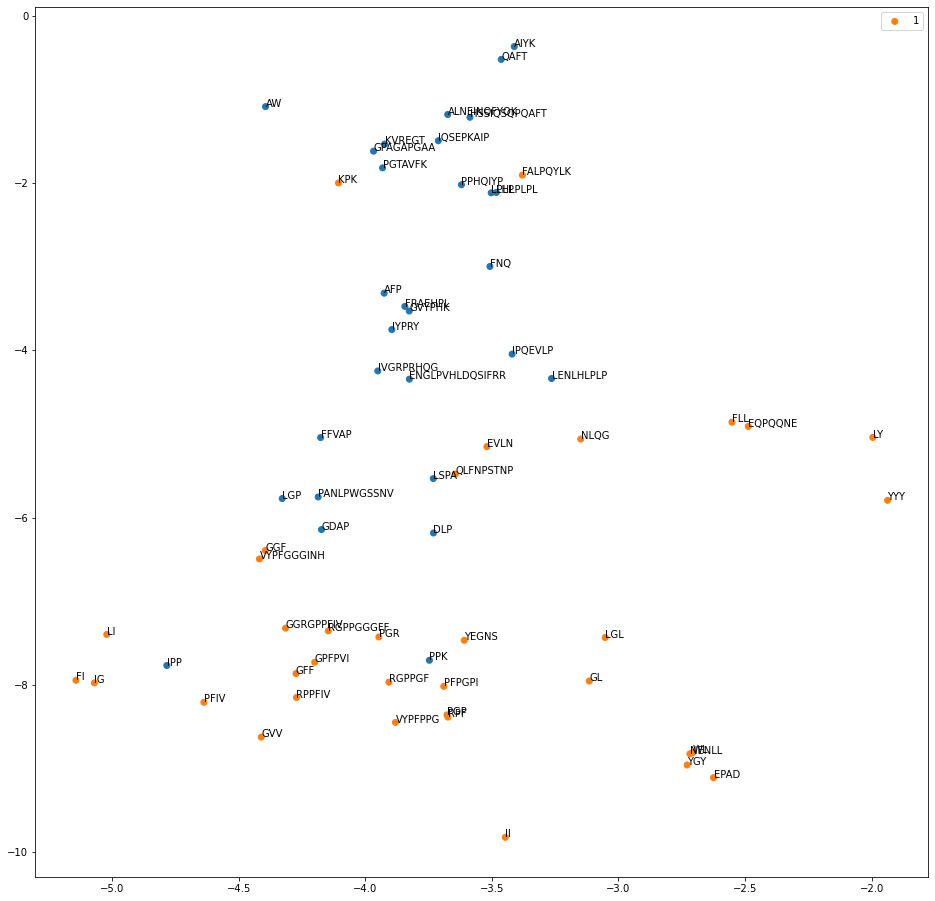

In [30]:
descs = []
conv_feats = np.zeros((len(test_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(test_graph_embeddings)):
    descs.append(test_graph_embeddings[i]['desc'])
    conv_feats[i] = test_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(test_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]))
plt.show()

## Node level embeddings: All Data 

In [31]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])


In [32]:
pos_samples = []
neg_samples = []
for i in range(len(conv_feats)):
    if labels[i] == 1:
        pos_samples.append(np.mean(conv_feats[i]))
    else:
        neg_samples.append(np.mean(conv_feats[i]))

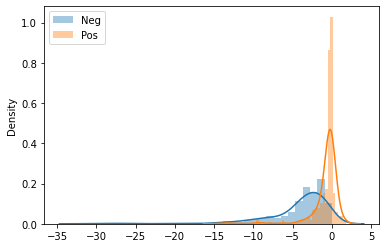

In [33]:
sns.distplot(neg_samples, label='Neg')
sns.distplot(pos_samples, label='Pos')
plt.legend()
plt.show()

del pos_samples, neg_samples

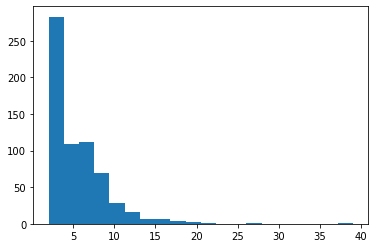

In [34]:
plt.hist([len(i) for i in descs], bins = 20)
plt.show()

In [35]:
pos_descs = {}
neg_descs = {}
for i in range(len(labels)):
    k = descs[i]
    v = conv_feats[i]
    if labels[i] == 1:
        for _, d in enumerate(k):
            if d in pos_descs.keys():
                pos_descs[d].append(v[_])
            else:
                pos_descs[d] = [v[_]]
    else:
        for _, d in enumerate(k):
            if d in neg_descs.keys():
                neg_descs[d].append(v[_])
            else:
                neg_descs[d] = [v[_]]

In [36]:
desc_keys = sorted(list(set(list(pos_descs.keys()) + list(neg_descs.keys()))))

In [37]:
pos_desc_avg = []
neg_desc_avg = []
desc_avg = []
pos_desc_count = np.arange(len(desc_keys))
neg_desc_count = np.arange(len(desc_keys))
for i, k in enumerate(desc_keys):
    if k in pos_descs.keys():
        pos_desc_avg.append(np.mean(pos_descs[k]))
        pos_desc_count[i] = pos_desc_count[i] + len(pos_descs[k])
    else:
        pos_desc_avg.append(0)

    if k in neg_descs.keys():
        neg_desc_avg.append(np.mean(neg_descs[k]))
        neg_desc_count[i] = neg_desc_count[i] + len(neg_descs[k])
    else:
        neg_desc_avg.append(0)

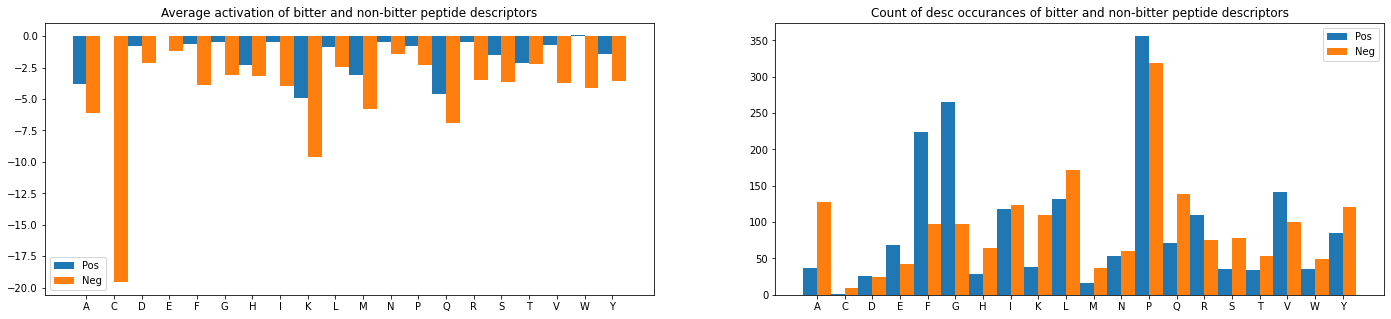

In [38]:
fig, ax = plt.subplots(1,2,figsize=(24,5))
ax[0].bar(x=np.arange(20)-0.25, height = pos_desc_avg, width=-.5)
ax[0].bar(x=np.arange(20)+0.25, height = neg_desc_avg, width=-.5)
ax[0].set_xticks(np.arange(20), desc_keys)
ax[0].legend(['Pos', 'Neg'])
ax[0].set_title('Average activation of bitter and non-bitter peptide descriptors')

ax[1].bar(x=np.arange(20)-0.25, height = pos_desc_count, width=-.5)
ax[1].bar(x=np.arange(20)+0.25, height = neg_desc_count, width=-.5)
ax[1].set_xticks(np.arange(20), desc_keys)
ax[1].legend(['Pos', 'Neg'])
ax[1].set_title('Count of desc occurances of bitter and non-bitter peptide descriptors')
plt.show()

Seq: VE, Label: 1, Cls prob: [-2.974891185760498, 2.803534507751465]


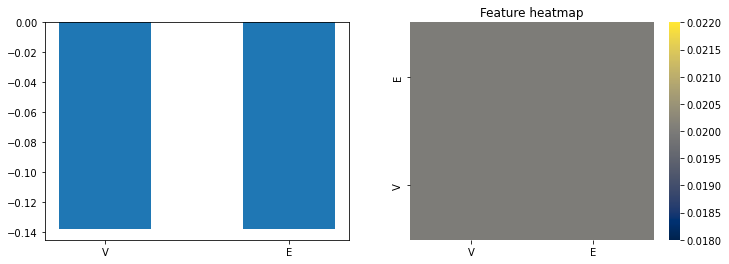

Seq: IAK, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


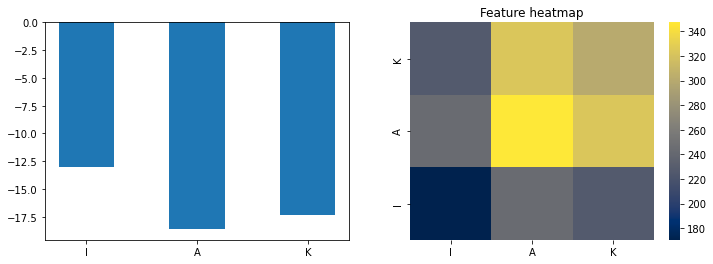

Seq: LAMA, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


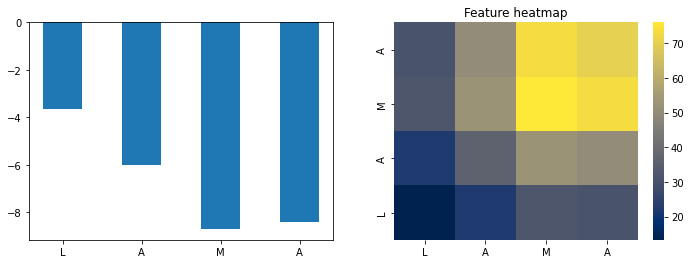

Seq: GVV, Label: 1, Cls prob: [-5.516465187072754, 5.3797383308410645]


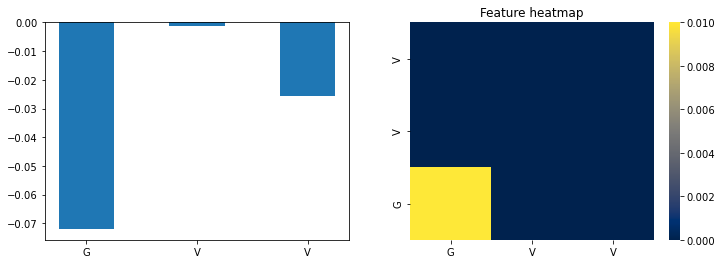

Seq: GYG, Label: 1, Cls prob: [-5.111001014709473, 4.3330864906311035]


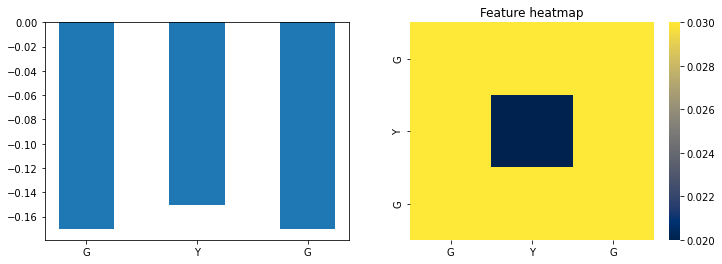

Seq: IYPRY, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


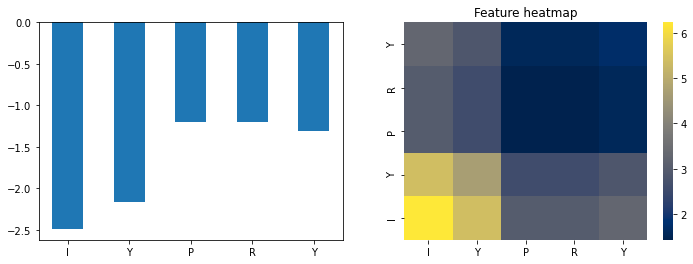

Seq: LQP, Label: 0, Cls prob: [1.0836865901947021, -1.0499402284622192]


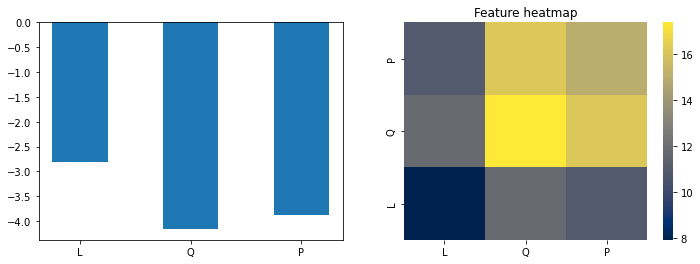

Seq: GL, Label: 1, Cls prob: [-4.872591018676758, 4.119582653045654]


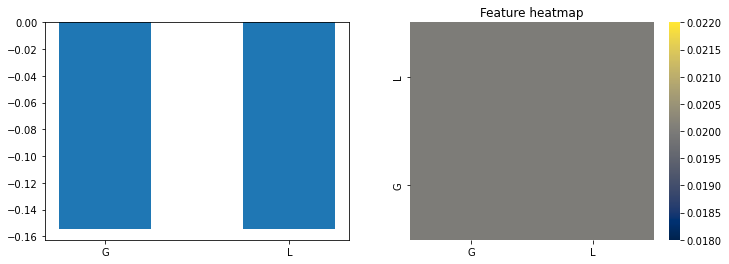

Seq: GPPF, Label: 1, Cls prob: [-3.445312023162842, 3.0999510288238525]


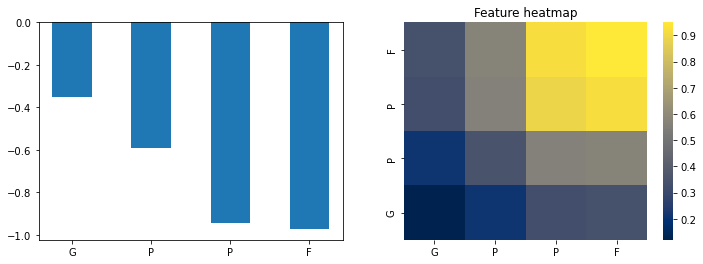

Seq: KL, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


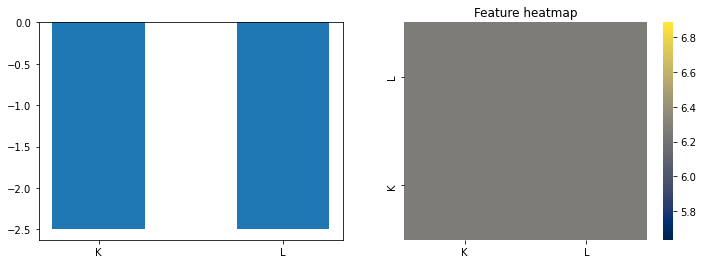

Seq: VYPFPPIGNH, Label: 1, Cls prob: [-2.451329469680786, 2.3365530967712402]


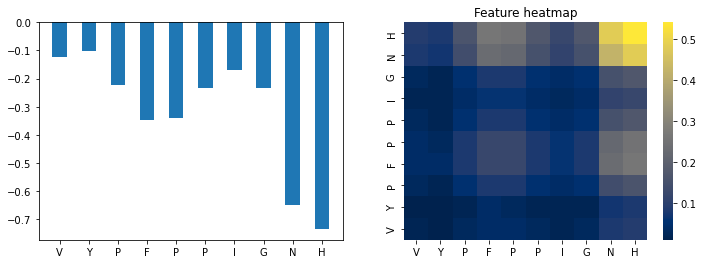

Seq: LNP, Label: 0, Cls prob: [1.335591435432434, -1.2285840511322021]


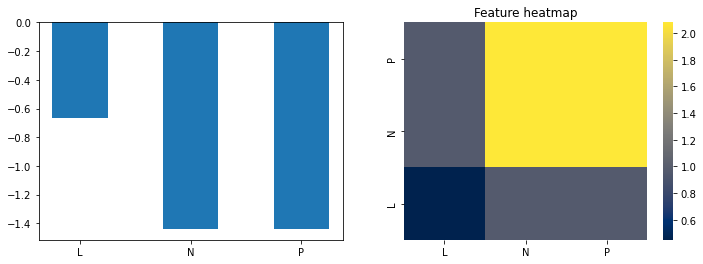

Seq: PGTAVFK, Label: 0, Cls prob: [1.0213826894760132, -0.9474239349365234]


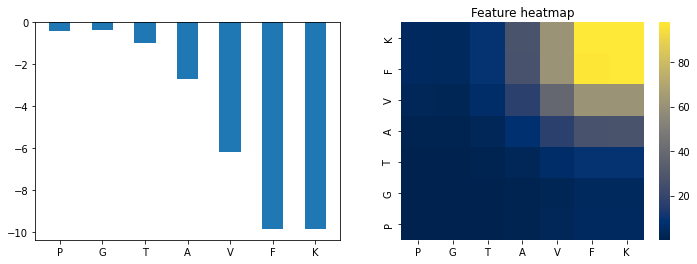

Seq: PLIYP, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


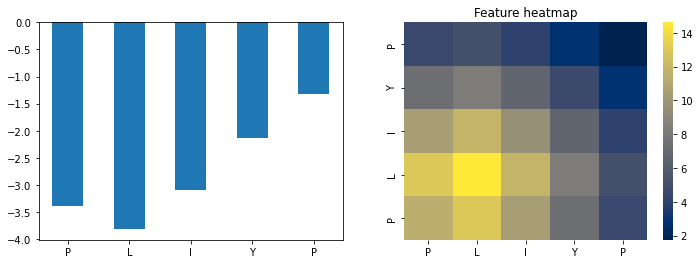

Seq: LD, Label: 1, Cls prob: [-13.989224433898926, 12.16377067565918]


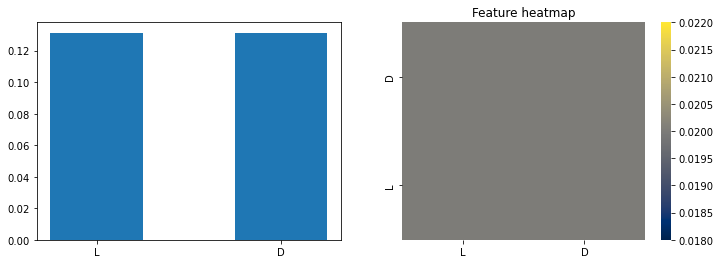

Seq: EE, Label: 1, Cls prob: [-42.036258697509766, 38.36956024169922]


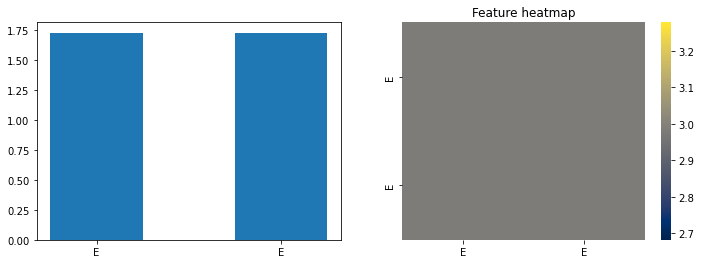

Seq: ENLHLPLP, Label: 0, Cls prob: [0.8877463340759277, -0.8454895615577698]


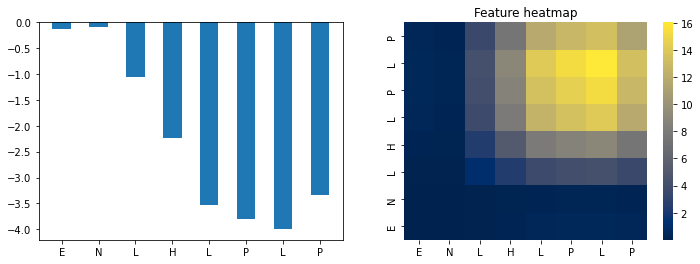

Seq: MPFPKYPVEPF, Label: 1, Cls prob: [-0.7663843035697937, 0.7325412631034851]


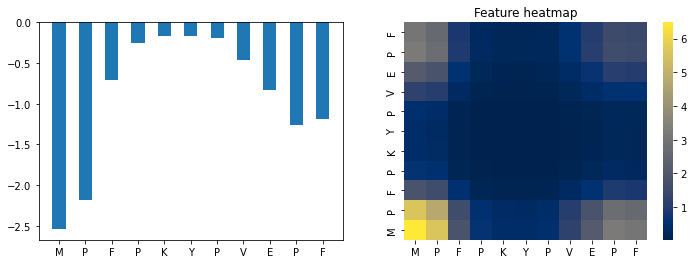

Seq: RGPPGIG, Label: 1, Cls prob: [-2.1233625411987305, 1.9785504341125488]


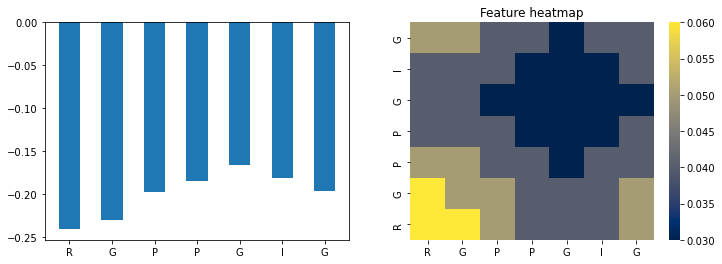

Seq: SAEFG, Label: 1, Cls prob: [-2.064908266067505, 1.7193877696990967]


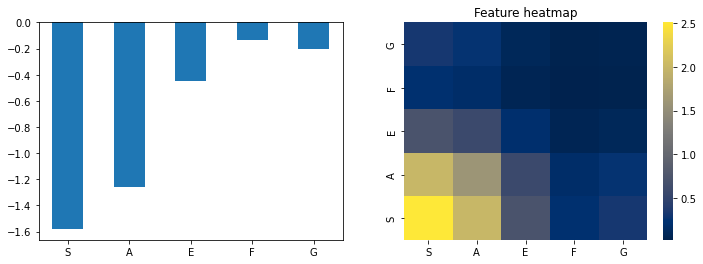

In [39]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 20):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #ax[0].plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    
    sns.heatmap(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i])))).round(2), cmap = 'cividis', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()

Seq: QQPVLGPVRGPFPI, Label: 1, Cls prob: [-1.540773630142212, 1.5431230068206787]


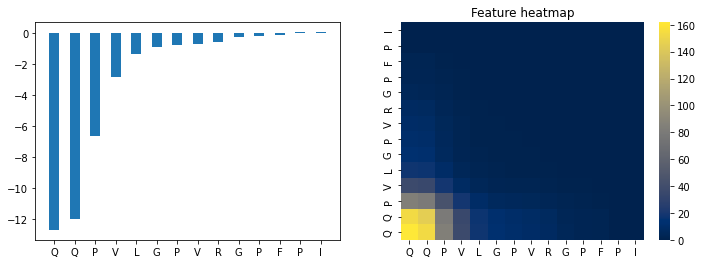

Seq: KFHSGIQSEPKAIP, Label: 0, Cls prob: [1.373789668083191, -1.2525660991668701]


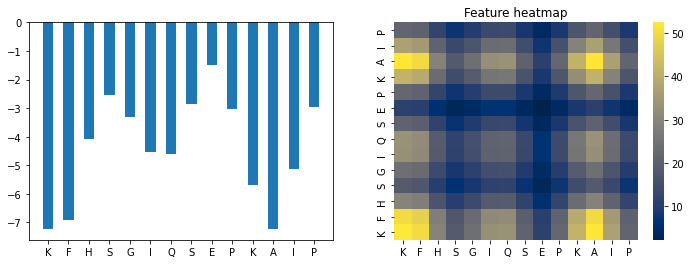

Seq: PVLGPVRGPFPIIV, Label: 1, Cls prob: [-4.303576946258545, 4.30359411239624]


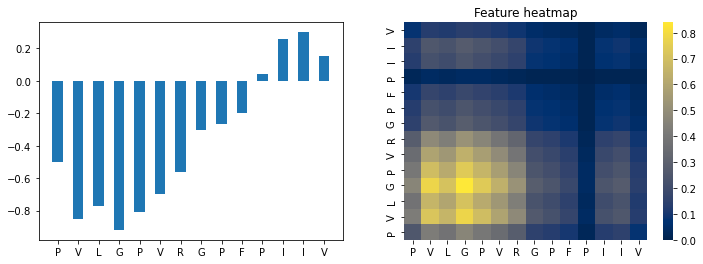

Seq: KIYPSFQPQPLIYP, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


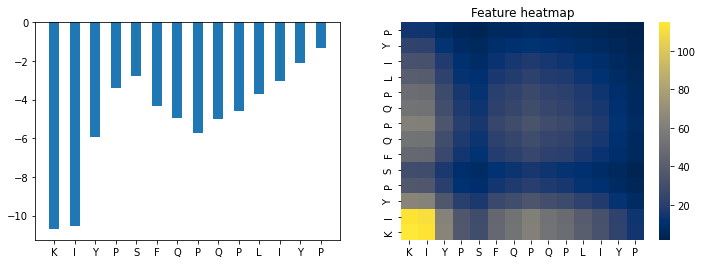

Seq: YQEPVLGPVRGPFPI, Label: 1, Cls prob: [-1.4391496181488037, 1.4325897693634033]


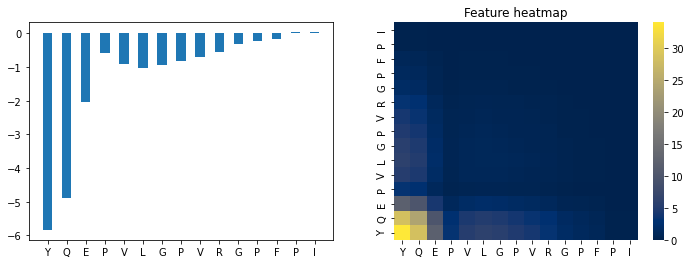

Seq: ENGLPVHLDQSIFRR, Label: 0, Cls prob: [0.8804749250411987, -0.8304333090782166]


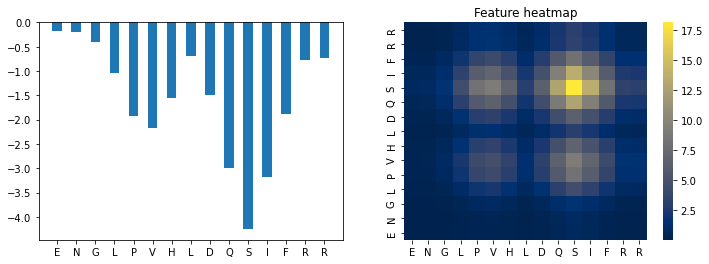

Seq: QPVLGPVRGPFPIIV, Label: 1, Cls prob: [-3.9697718620300293, 3.983673334121704]


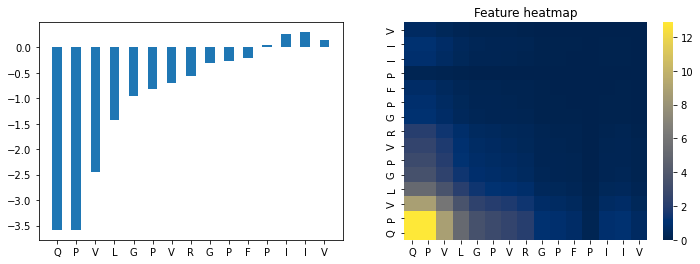

Seq: DKIYPSFQPQPLIYP, Label: 0, Cls prob: [1.3856861591339111, -1.2642844915390015]


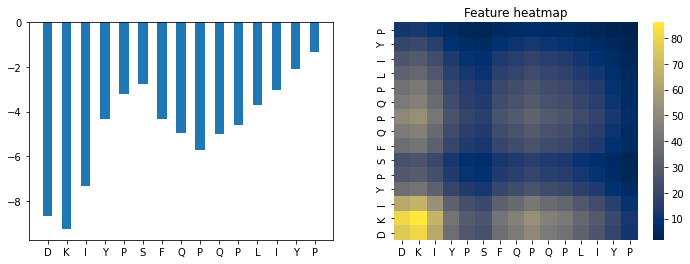

Seq: YQQPVLGPVRGPFPI, Label: 1, Cls prob: [-1.3626148700714111, 1.3722119331359863]


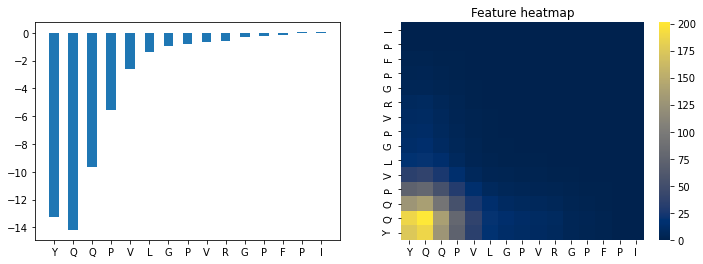

Seq: YQQPVLGPVRGPFPII, Label: 1, Cls prob: [-7.57960319519043, 7.428571701049805]


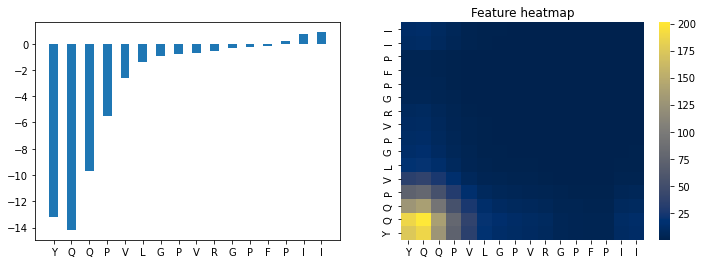

Seq: ENGLPVHLDQSIFRRP, Label: 0, Cls prob: [0.7093555927276611, -0.6793266534805298]


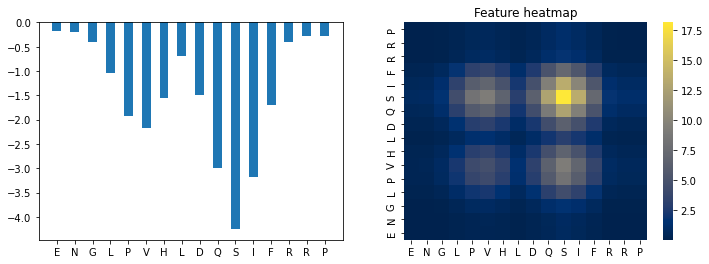

Seq: APKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.009794533252716064, 0.010795295238494873]


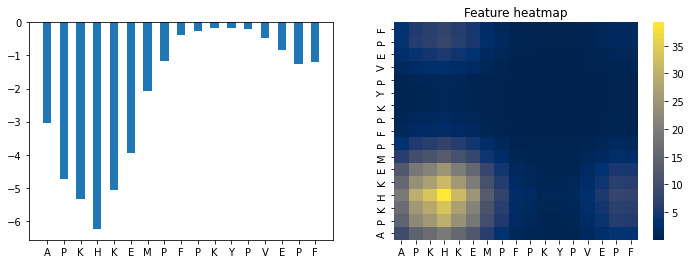

Seq: YQQPVLGPVRGPFPIIV, Label: 1, Cls prob: [-3.5761094093322754, 3.5982539653778076]


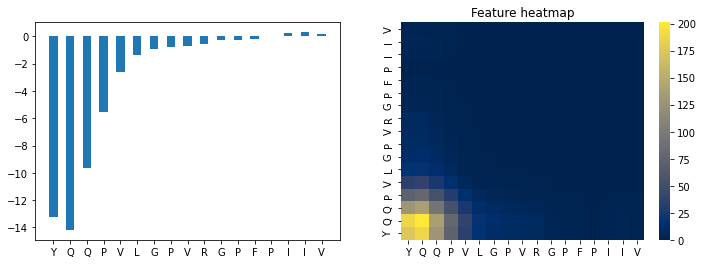

Seq: YQEPVLGPVRGPFPIIV, Label: 1, Cls prob: [-3.638204574584961, 3.6507880687713623]


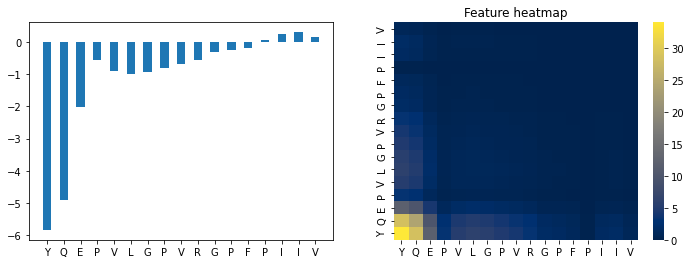

Seq: MAPKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.09964156150817871, -0.07246869802474976]


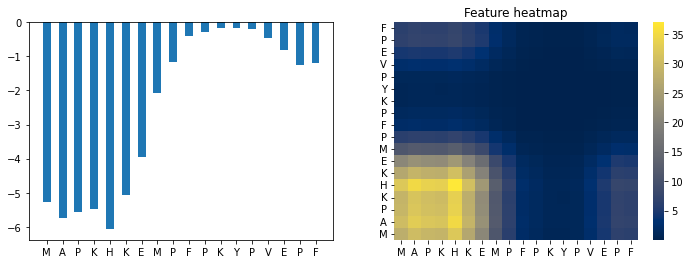

Seq: LVYPFPGPIPNSLPQNIPP, Label: 0, Cls prob: [-0.5558884739875793, 0.4683097004890442]


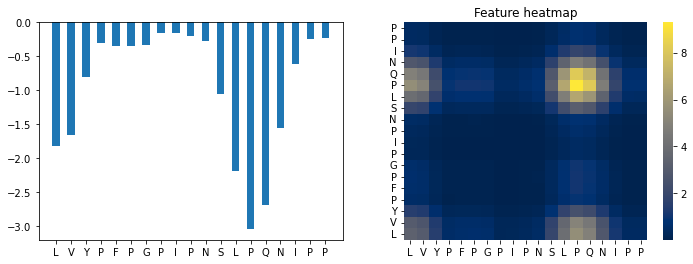

Seq: QDKIHPFAQTQSLVYPFPGP, Label: 1, Cls prob: [0.23975151777267456, -0.27990901470184326]


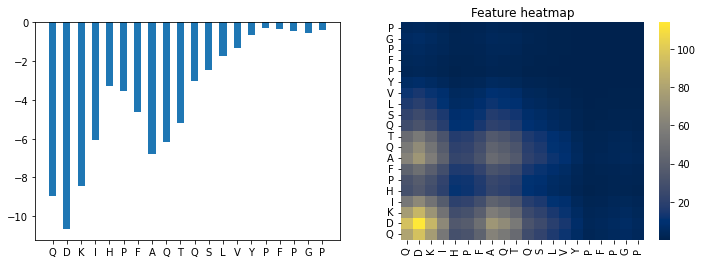

Seq: QNDKIHPFAQTQSLVYPFGPIP, Label: 1, Cls prob: [-0.2965487837791443, 0.25782233476638794]


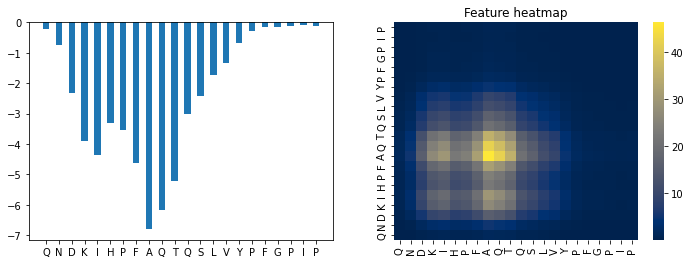

Seq: AQTQSLVYPFPGPIPNSLPQNIPPLTQ, Label: 1, Cls prob: [0.07541841268539429, -0.1341131329536438]


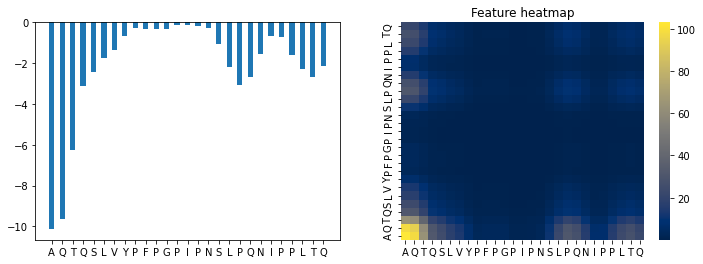

Seq: QNDKIHPFAQTQSLVYPFGPIPNSLPQNIPPLTQTPVVV, Label: 1, Cls prob: [-0.8017310500144958, 0.7793864607810974]


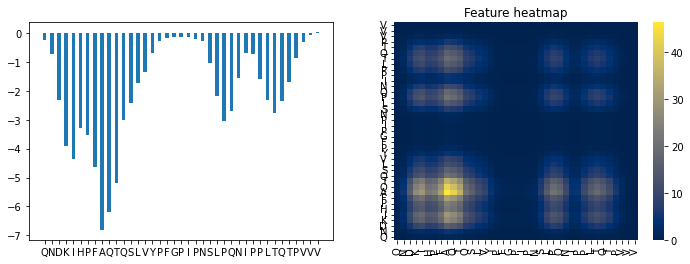

In [40]:
#i = np.random.randint(640)
#print(i)
for i in np.argsort([len(i) for i in descs])[-20:]:
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #ax[0].plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    
    sns.heatmap(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i])))).round(2), cmap = 'cividis', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()

In [41]:
descs[0]

'PFIV'